# Modelos a implementar

En esta situacion vamos a implementar algunos de los modelos de aprendizaje supervisado y comparar cuales quedan mejor adaptadas para el problema a partir de métricas y definiciones que se determinarán durante el desarrollo.

# 1. K-Vecinos Cercanos

In [1]:
#Importacion de las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Cargamos el dataframe procesado de nuestro repositorio de GitHub
url = 'https://raw.githubusercontent.com/Axumis/Parcial_Aprendizaje_Automatico/refs/heads/main/data/processed/dataset_con_riesgo.csv'
df = pd.read_csv(url)

#Mostramos el dataframe
df

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],Riesgo
0,6.273000,63.0,0.0,20.780453,Alto
1,6.273000,64.0,0.0,20.380579,Alto
2,7.023000,60.0,0.0,22.530937,Alto
3,8.023000,55.0,0.0,27.193705,Muy alto
4,8.672999,53.0,0.0,26.400545,Alto
...,...,...,...,...,...
22022,-1.327000,84.0,0.0,3.545589,Moderado
22023,-1.827000,88.0,0.0,3.826853,Moderado
22024,-2.227000,91.0,0.0,4.104631,Moderado
22025,-2.177000,92.0,0.0,3.826853,Moderado


Preparamos el dataset

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
X= df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]']].values
y= df['Riesgo'].values

# 1. Codificamos las etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#2. Dividimos los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Escalamos las features tanto de entrenamiento como de prueba
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicamos PCA
pca = PCA(n_components=2) # Reducimos a 2 dimensiones para el grafico
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Creamos el modelo

In [46]:
# 5. Entrenamos y predecimos
k = 3 #Asignamos un valor de k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

Visualizamos el entrenamiento (Utilizando PCA para reducir dimensiones)

Gráfica de la Clasificación Obtenida

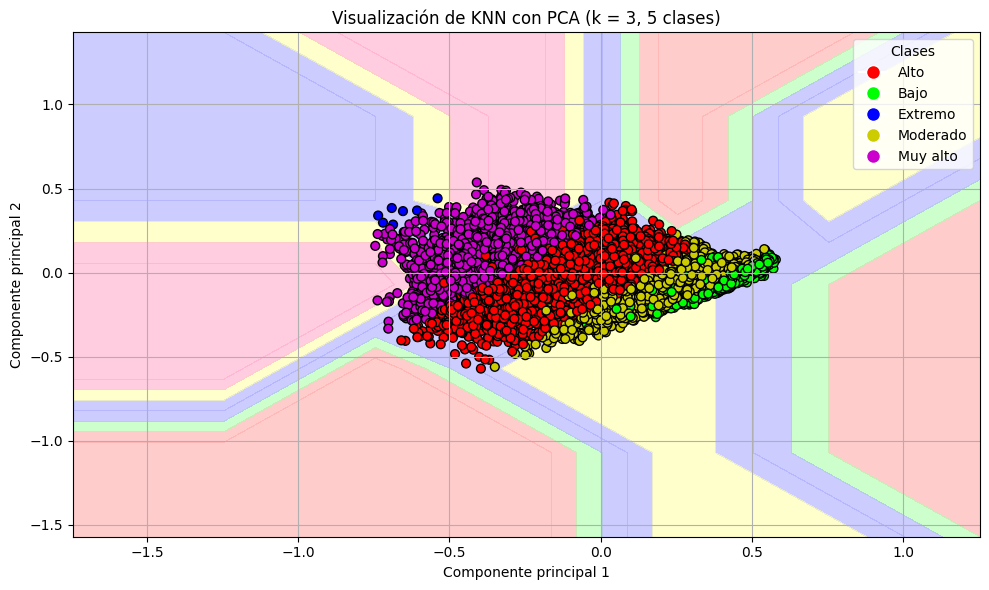

In [47]:
# Crear malla para frontera de decisión
h = 0.5
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Colores
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFFAA', '#FFAACC'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#CCCC00', '#CC00CC'])

# Graficar
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
                      cmap=cmap_bold, edgecolor='k', s=40)

# Crear leyenda con los nombres originales de las clases
legend_labels = le.inverse_transform(np.unique(y_train))
legend_colors = [scatter.cmap(scatter.norm(i)) for i in np.unique(y_train)]
patches = [plt.Line2D([0], [0], marker='o', color='w',
                      label=label, markerfacecolor=color, markersize=10)
           for label, color in zip(legend_labels, legend_colors)]

plt.legend(handles=patches, title="Clases")
plt.title(f"Visualización de KNN con PCA (k = {k}, {len(legend_labels)} clases)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


Predicciones del modelo

In [48]:
# Predicciones
y_pred = knn.predict(X_test_pca)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_encoded))))

Accuracy: 0.91

Reporte de clasificación:
              precision    recall  f1-score   support

        Alto       0.95      0.95      0.95      2574
        Bajo       0.81      0.71      0.76       497
     Extremo       1.00      0.33      0.50         3
    Moderado       0.87      0.87      0.87      1482
    Muy alto       0.93      0.98      0.95       951

    accuracy                           0.91      5507
   macro avg       0.91      0.77      0.81      5507
weighted avg       0.91      0.91      0.91      5507



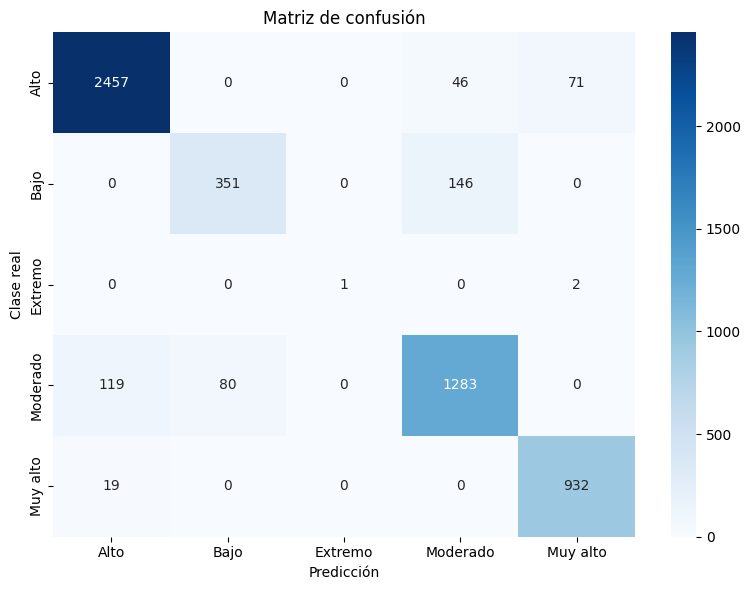

In [49]:
# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.inverse_transform(np.unique(y_encoded)),
            yticklabels=le.inverse_transform(np.unique(y_encoded)))
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()

Creamos el Modelo 2da opcion sin usar PCA

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
X= df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]']].values
y= df['Riesgo'].values


#1. Dividimos los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Escalamos las features tanto de entrenamiento como de prueba
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
# 5. Entrenamos y predecimos
k = 3 #Asignamos un valor de k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
# Predicciones
y_pred = knn.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_encoded))))

Accuracy: 0.96

Reporte de clasificación:
              precision    recall  f1-score   support

        Alto       0.97      0.98      0.97      2574
        Bajo       0.96      0.92      0.94       497
     Extremo       1.00      0.33      0.50         3
    Moderado       0.96      0.95      0.95      1482
    Muy alto       0.96      0.98      0.97       951

    accuracy                           0.96      5507
   macro avg       0.97      0.83      0.87      5507
weighted avg       0.96      0.96      0.96      5507



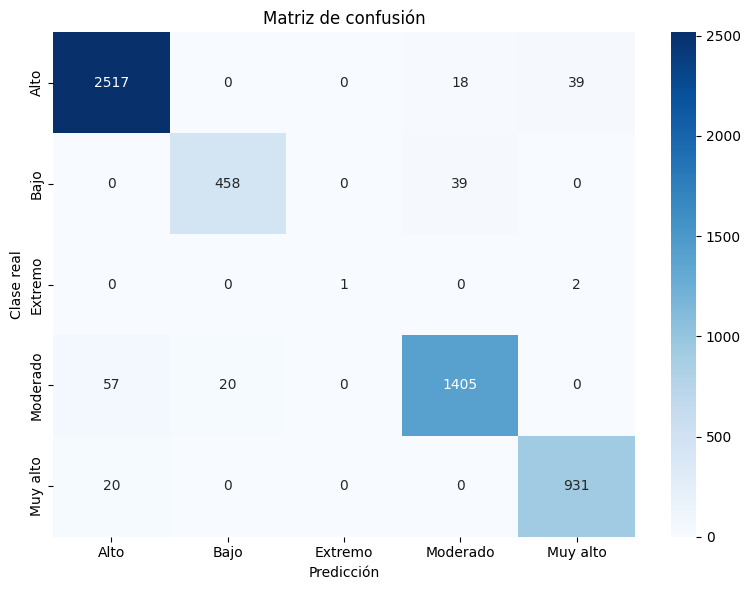

In [53]:
# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.inverse_transform(np.unique(y_encoded)),
            yticklabels=le.inverse_transform(np.unique(y_encoded)))
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()